
# Water Quality Classification using Machine Learning

## Author: Fabrice Faustin

This project analyzes groundwater quality data from Telangana, India. The goal is to classify water samples based on their chemical properties to determine their suitability for agriculture.

We compare **Decision Tree** and **K-Nearest Neighbors (KNN)** models, evaluate them across hyperparameters using cross-validation, and select the best-performing model based on mean accuracy and precision.


## 1. Load and Preview the Dataset

We begin by importing the raw dataset and inspecting its structure.

In [1]:
import pandas as pd

df = pd.read_csv('ground_water_quality_2018_post.csv')
print("Initial dataset shape:", df.shape)
df.head()


Initial dataset shape: (374, 26)


,sno,district,mandal,village,lat_gis,long_gis,gwl,season,pH,E.C,...,SO4,Na,K,Ca,Mg,T.H,SAR,Classification,RSC meq / L,Classification.1
0,1,ADILABAD,Adilabad,Adilabad,19.668300,78.524700,5.09,postmonsoon 2018,8.28,745,...,46.0,49.0,4.0,48,38.896,279.934211,1.273328,C2S1,-1.198684,P.S.
1,2,ADILABAD,Bazarhatnur,Bazarhatnur,19.458888,78.350833,5.10,postmonsoon 2018,8.29,921,...,68.0,42.0,5.0,56,63.206,399.893092,0.913166,C3S1,-3.397862,P.S.
2,3,ADILABAD,Gudihatnoor,Gudihatnoor,19.525555,78.512222,4.98,postmonsoon 2018,7.69,510,...,44.0,45.0,2.0,24,38.896,219.934211,1.319284,C2S1,-0.398684,P.S.
3,4,ADILABAD,Jainath,Jainath,19.730555,78.640000,5.75,postmonsoon 2018,8.09,422,...,35.0,27.0,1.0,32,19.448,159.967105,0.928155,C2S1,0.000658,P.S.
4,5,ADILABAD,Narnoor,Narnoor,19.495665,78.852654,2.15,postmonsoon 2018,8.21,2321,...,280.0,298.0,5.0,56,92.378,519.843750,5.682664,C4S2,-4.396875,P.S.


## 2. Select Relevant Features

The dataset includes both geographic and chemical properties. For this project, I decided to focus on the chemical measurements I believe are most relevant to groundwater quality and remove location-based and descriptive identifiers. I also retain the target (Classification) column, which labels each sample according to irrigation suitability.

In [2]:

selected_features = list(df.columns[4:7]) + list(df.columns[8:23])
df_filtered = df[selected_features + ['Classification']]
print("Filtered dataset shape:", df_filtered.shape)
df_filtered.head()


Filtered dataset shape: (374, 19)


,lat_gis,long_gis,gwl,pH,E.C,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,T.H,SAR,Classification
0,19.668300,78.524700,5.09,8.28,745,476.80,0,220.0,60,0.44,42.276818,46.0,49.0,4.0,48,38.896,279.934211,1.273328,C2S1
1,19.458888,78.350833,5.10,8.29,921,589.44,0,230.0,80,0.56,100.659091,68.0,42.0,5.0,56,63.206,399.893092,0.913166,C3S1
2,19.525555,78.512222,4.98,7.69,510,326.40,0,200.0,30,0.66,41.471545,44.0,45.0,2.0,24,38.896,219.934211,1.319284,C2S1
3,19.730555,78.640000,5.75,8.09,422,270.08,0,160.0,10,0.58,10.669864,35.0,27.0,1.0,32,19.448,159.967105,0.928155,C2S1
4,19.495665,78.852654,2.15,8.21,2321,1485.44,0,300.0,340,2.56,128.843636,280.0,298.0,5.0,56,92.378,519.843750,5.682664,C4S2


## 3. Visualize Missing Values (Before Cleaning

Before proceeding with preprocessing, we analyze the dataset for missing values. Visualizing this helps us assess the extent and distribution of incomplete data across features.

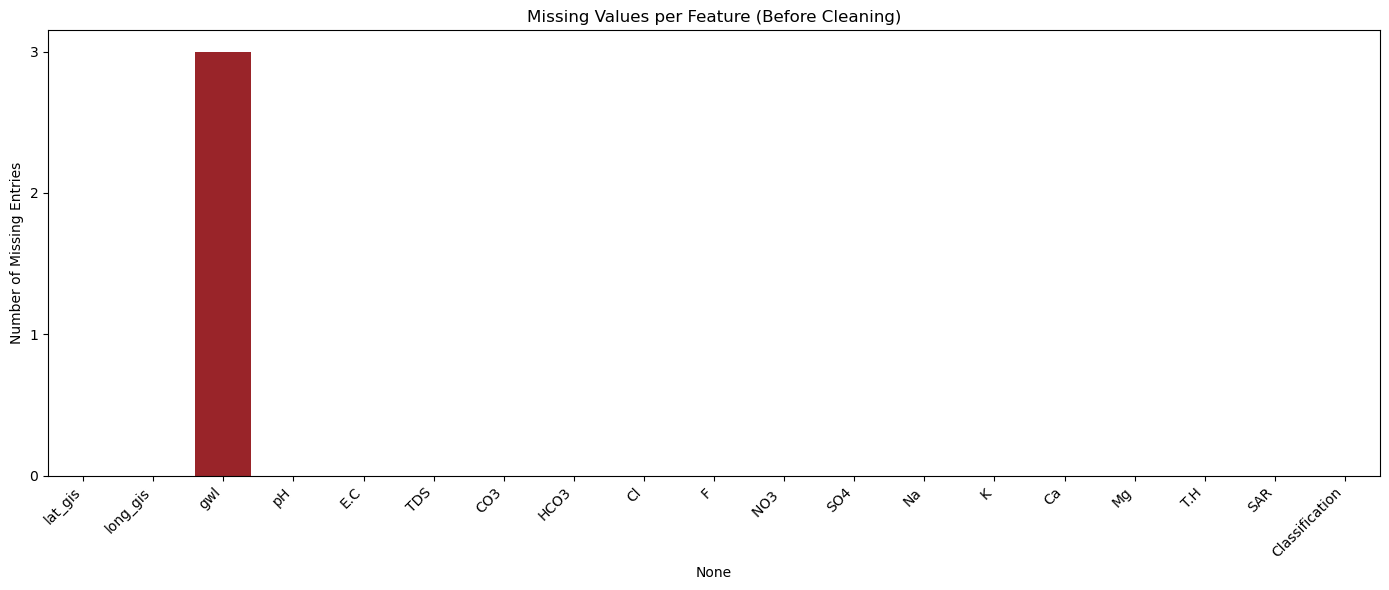

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

missing_counts_all = df_filtered.isnull().sum()

plt.figure(figsize=(14, 6))
sns.barplot(
    x=missing_counts_all.index,
    y=missing_counts_all.values,
    hue=missing_counts_all.index,
    palette='Reds_r',
    legend=False
)
plt.title('Missing Values per Feature (Before Cleaning)')
plt.ylabel('Number of Missing Entries')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


## 4. Clean Missing Data

To handle missing values, we replace all null entries with `0.0`. This approach assumes that missing chemical measurements indicate undetectable or trace-level presence. This decision is made to preserve row count while preparing the data for machine learning.

In [4]:
df_clean = df_filtered.fillna(0)
X = df_clean.drop(columns='Classification')
y = df_clean['Classification']


## 5. Confirm Cleaning

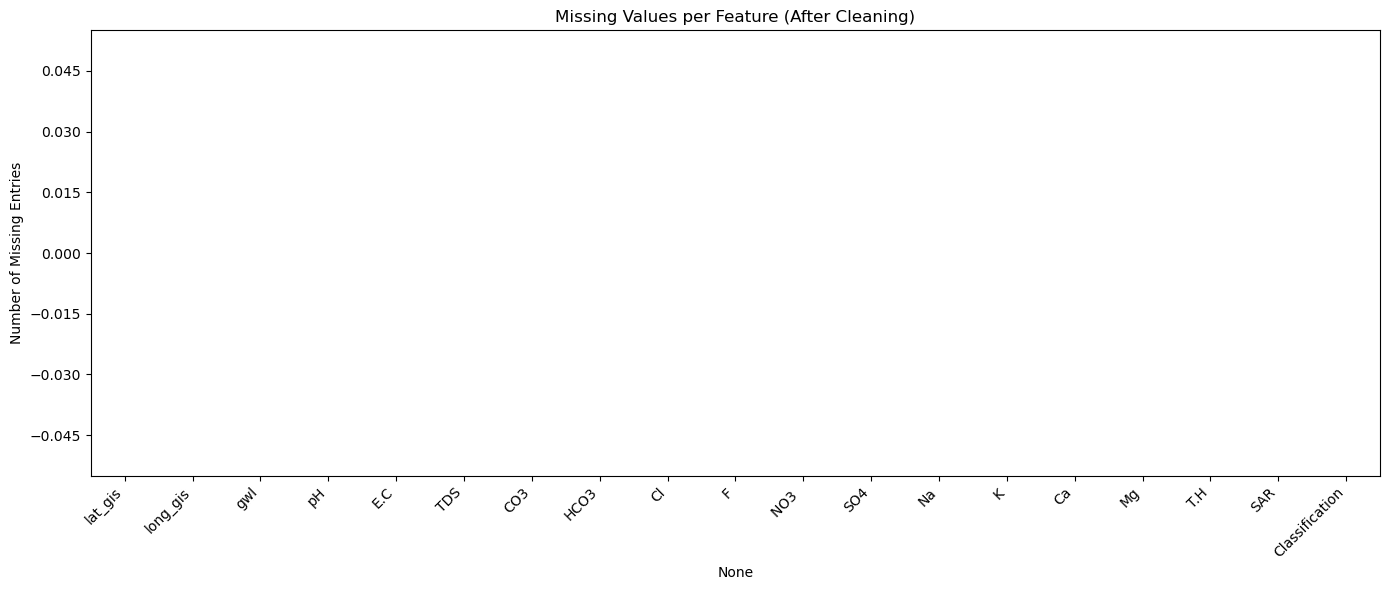

In [5]:
missing_counts_all_after = df_clean.isnull().sum()

plt.figure(figsize=(14, 6))
sns.barplot(
    x=missing_counts_all_after.index,
    y=missing_counts_all_after.values,
    hue=missing_counts_all_after.index,
    palette='Greens',
    legend=False
)
plt.title('Missing Values per Feature (After Cleaning)')
plt.ylabel('Number of Missing Entries')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


## 6. Remove Rare Classes

Some classes in the target variable have very few examples, which can destabilize cross-validation and hurt model performance. We remove all classes with fewer than 5 samples to ensure a balanced and meaningful classification task.

Below, we compare the class distribution before and after filtering.

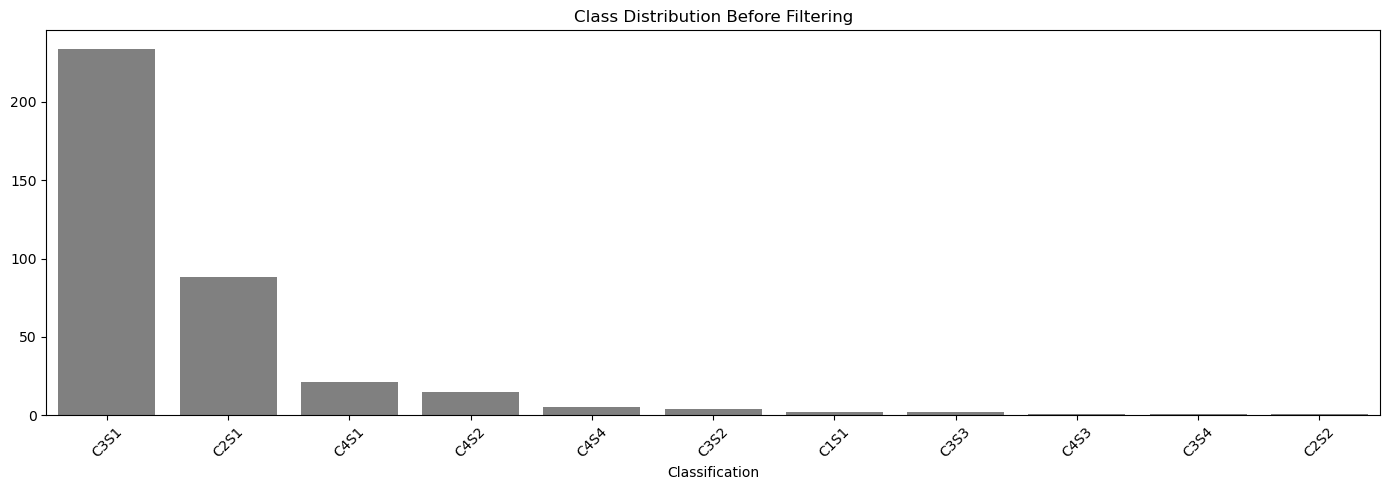

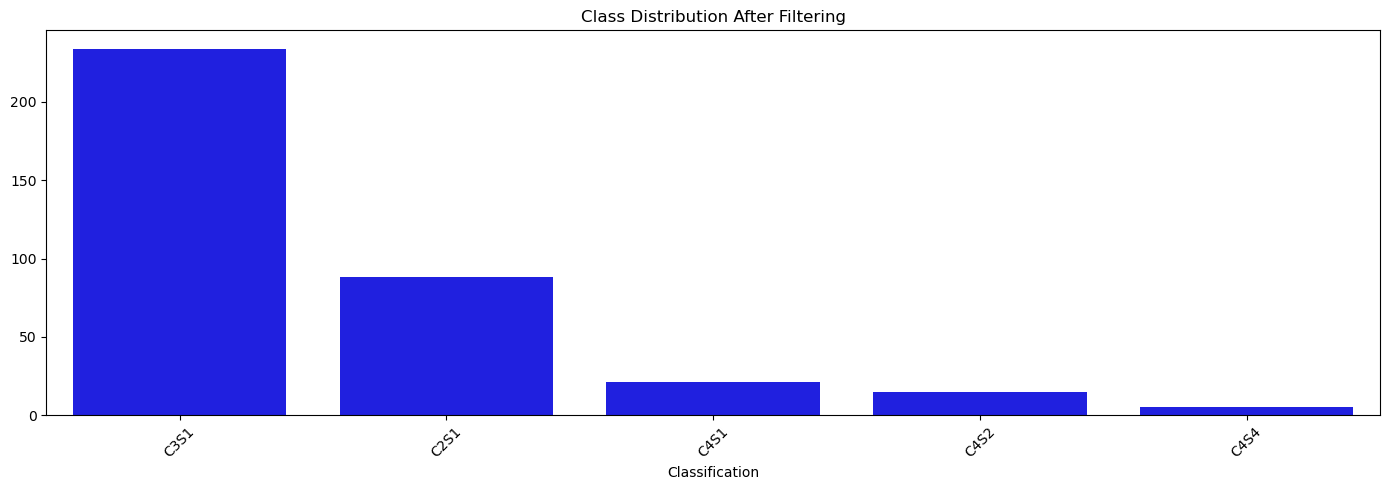

In [6]:
old_counts = y.value_counts()
valid_classes = old_counts[old_counts >= 5].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

new_counts = y_filtered.value_counts()

# Plot before and after
plt.figure(figsize=(14, 5))
sns.barplot(x=old_counts.index, y=old_counts.values, color='gray')
plt.title("Class Distribution Before Filtering")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x=new_counts.index, y=new_counts.values, color='blue')
plt.title("Class Distribution After Filtering")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7. Train-Test Split

We now split the dataset into training and test sets. This allows us to evaluate our models on unseen data after training and cross-validation. We use stratification to maintain class balance between the training and test sets.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (290, 18)
Test set size: (73, 18)


## 8. Decision Tree Evaluation

We evaluate three Decision Tree models with different `max_depth` values. For each model:
- We compute the **mean cross-validation accuracy** using 5 folds.
- We compute **weighted precision** on the test set.

This helps us identify the best-performing depth configuration and analyze its trade-offs.

,Model,Mean Accuracy,Precision
0,DT (max_depth=3),0.944838,0.965753
1,DT (max_depth=5),0.941330,0.975342
2,DT (max_depth=7),0.934386,0.952055


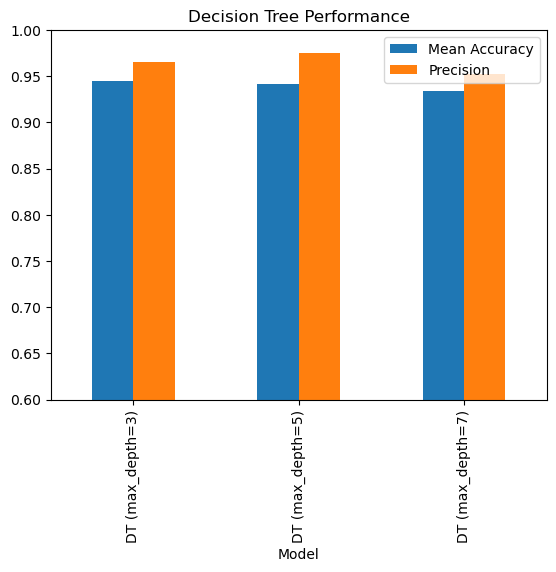

In [8]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

dt_results = []

for max_depth in [3, 5, 7]:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    acc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    dt_results.append({'Model': f'DT (max_depth={max_depth})', 'Mean Accuracy': acc_scores.mean(), 'Precision': prec})

dt_df = pd.DataFrame(dt_results)
display(dt_df)## 9. KNN Evaluation

dt_df.set_index('Model')[['Mean Accuracy', 'Precision']].plot(kind='bar', ylim=(0.6, 1.0), title="Decision Tree Performance")
plt.show()



## 9. KNN Evaluation

We evaluate three K-Nearest Neighbors models with different `k` values. Similar to the Decision Tree evaluation, we calculate both:
- Mean cross-validation accuracy
- Weighted precision on the test set

This gives us insight into how the number of neighbors affects KNN's performance.

,Model,Mean Accuracy,Precision
0,KNN (k=5),0.930985,0.947945
1,KNN (k=10),0.924148,0.948666
2,KNN (k=15),0.910295,0.891703


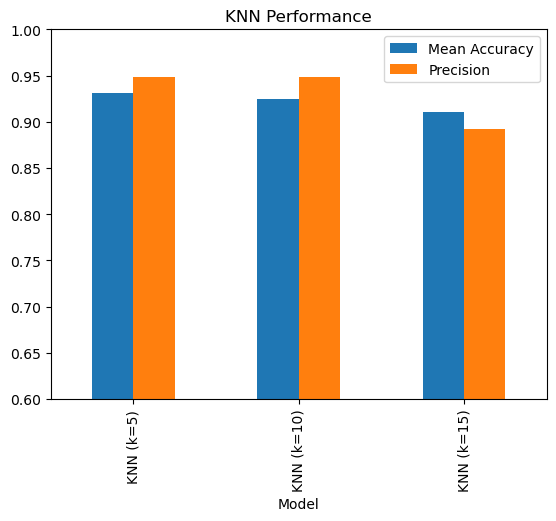

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_results = []

for k in [5, 10, 15]:
    model = KNeighborsClassifier(n_neighbors=k)
    acc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    knn_results.append({'Model': f'KNN (k={k})', 'Mean Accuracy': acc_scores.mean(), 'Precision': prec})

knn_df = pd.DataFrame(knn_results)
display(knn_df)
knn_df.set_index('Model')[['Mean Accuracy', 'Precision']].plot(kind='bar', ylim=(0.6, 1.0), title="KNN Performance")
plt.show()



## 10. Final Comparison: Best Models

From our earlier evaluation, we select the best-performing model from each technique:

- **Decision Tree**: max_depth = 5
- **KNN**: k = 10

We now compare these two models side-by-side using both accuracy and precision metrics.
y.


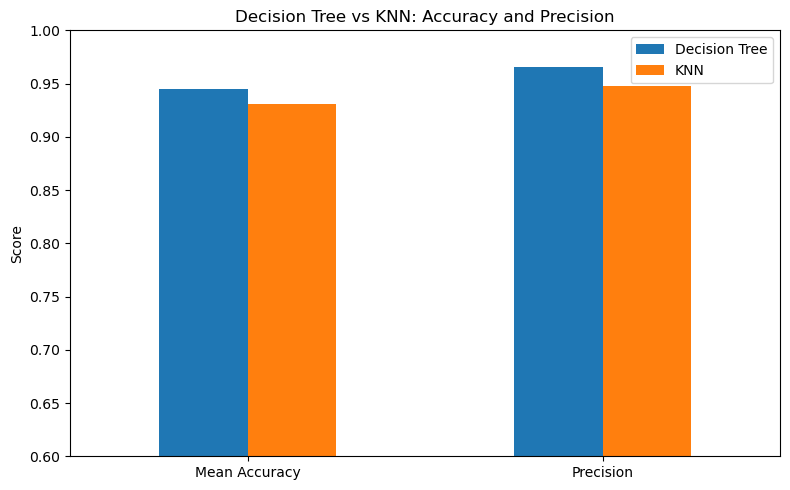

,Decision Tree,KNN
Mean Accuracy,0.944838,0.930985
Precision,0.965753,0.947945


In [10]:
# Extract best-performing models
best_dt = dt_df.loc[dt_df['Mean Accuracy'].idxmax()]
best_knn = knn_df.loc[knn_df['Mean Accuracy'].idxmax()]

# Create metric-focused comparison
comparison_by_metric = pd.DataFrame({
    'Decision Tree': [best_dt['Mean Accuracy'], best_dt['Precision']],
    'KNN': [best_knn['Mean Accuracy'], best_knn['Precision']]
}, index=['Mean Accuracy', 'Precision'])

# Plot
comparison_by_metric.plot(kind='bar', figsize=(8, 5), ylim=(0.6, 1.0), title='Decision Tree vs KNN: Accuracy and Precision')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Display table for clarity
comparison_by_metric


## 11. Conclusion & Future Work

Our analysis shows that the **Decision Tree model (max_dept3=5)** outperformed KNN across both accuracy and precision, making it a better choice for classifying groundwater based on chemical features.
  🔍 Key Insights:
- Simple chemical indicators like pH, Electrical Conductivity, and Sodium are strong predictors of irrigation suitability.
- Cross-validation with fewer folds (3-fold) was necessary due to class frequency limitations and helped stabilize our evaluation.
- Decision Trees are well-suited for structured, numeric datasets and handle feature thresholds effectively
### ⚠️ Limitations:
- The dataset is imbalanced, with certain water classes being far more represented than others.
- Using `0.0` to fill missing values may introduce bias if missingness is not random.
- Rare classes were removed, which may ignore extreme but real-world scenos.

### 🚀 Future Improvements:
- Experiment with ensemble models (e.g., Random Forest, Gradient Boosting).
- Use SMOTE or class-weighted training to handle imbalance instead of filtering.
- Explore time-aware modeling if seasonal data becomes available.

This project demonstrates the potential of machine learning in environmental monitoring and resource planning, especially in regions dependent on groundwater for agriculture.
